In [353]:
import numpy as np
from scipy.stats import zscore
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os

**incoming**	>> total incoming for that day

**backlog24hrs** >>	backlog > 24 h at the end of the day (emails that were yet to be answered and older than 24hrs)

**backlog_start_day** >> backlog at the start of the day (previous day end of day figure)

**backlog>24h_start_day** >>	backlog > 24 h at the start of the day (previous day end of day figure)

**head_sla** >>	% of the emails incoming on that day that were answered within 24 h


**backlog_start_of_the_day - backlog24hrs_start_of_the_day** = backlogs newer than 24 hrs

### Email aging & Backlog Analysis

In [354]:
df = pd.read_csv(r'V1 Backlog and SLA relation.csv')
df.head()

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla
0,2023-01-31,de,1716.0,NaN,NaN,0.853147
1,2023-01-31,en,1145.0,NaN,NaN,0.919651
2,2023-01-31,es,390.0,NaN,NaN,0.905128
3,2023-01-31,fr,664.0,NaN,NaN,0.950301
4,2023-01-31,it,354.0,NaN,NaN,0.861582


In [355]:
def weekday(day):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return days[day.weekday()]

# Convert 'day' column to datetime and extract day of the week
df['day'] = pd.to_datetime(df['day'])
df['dow'] = df['day'].apply(weekday)
df.head()

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow
0,2023-01-31,de,1716.0,NaN,NaN,0.853147,Tuesday
1,2023-01-31,en,1145.0,NaN,NaN,0.919651,Tuesday
2,2023-01-31,es,390.0,NaN,NaN,0.905128,Tuesday
3,2023-01-31,fr,664.0,NaN,NaN,0.950301,Tuesday
4,2023-01-31,it,354.0,NaN,NaN,0.861582,Tuesday


In [356]:
# fill NAs with 0
df.fillna(0, inplace=True)
df.head()

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow
0,2023-01-31,de,1716.0,0.0,0.0,0.853147,Tuesday
1,2023-01-31,en,1145.0,0.0,0.0,0.919651,Tuesday
2,2023-01-31,es,390.0,0.0,0.0,0.905128,Tuesday
3,2023-01-31,fr,664.0,0.0,0.0,0.950301,Tuesday
4,2023-01-31,it,354.0,0.0,0.0,0.861582,Tuesday


In [357]:
#check if we have incoming == 0
df[df['incoming'] == 0]

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow
3655,2025-01-31,de,0.0,1727.0,1013.0,0.0,Friday
3656,2025-01-31,en,0.0,1930.0,1654.0,0.0,Friday
3657,2025-01-31,es,0.0,304.0,145.0,0.0,Friday
3658,2025-01-31,fr,0.0,510.0,246.0,0.0,Friday
3659,2025-01-31,it,0.0,224.0,116.0,0.0,Friday
...,...,...,...,...,...,...,...
12630,2029-12-31,de,0.0,1727.0,1727.0,0.0,Monday
12631,2029-12-31,en,0.0,1930.0,1930.0,0.0,Monday
12632,2029-12-31,es,0.0,304.0,304.0,0.0,Monday
12633,2029-12-31,fr,0.0,510.0,510.0,0.0,Monday


In [358]:
# drop all rows where incoming == 0
df = df[df['incoming'] != 0]

In [359]:
df['incoming_zscore'] = zscore(df['incoming'])
df['backlog_zscore'] = zscore(df['backlog_start_of_the_day'])

# outliers (Z-score beyond ±3)
df['outlier_incoming'] = df['incoming_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)
df['outlier_backlog'] = df['backlog_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)

Q1 = df['incoming'].quantile(0.25)
Q3 = df['incoming'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['outlier_incoming'] = (df['incoming'] < lower_bound) | (df['incoming'] > upper_bound)
df['outlier_incoming'] = df['outlier_incoming'].astype(int)

In [360]:
# count how many outliers do we have
outliers = df[(df['outlier_incoming'] == 1) & (df['outlier_backlog'] == 1)]
outliers

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow,incoming_zscore,backlog_zscore,outlier_incoming,outlier_backlog
3220,2024-11-05,de,2423.0,7503.0,5706.0,0.312010,Tuesday,2.940319,3.203077,1,1
3225,2024-11-06,de,2329.0,8144.0,6302.0,0.347789,Wednesday,2.777192,3.530157,1,1
3250,2024-11-11,de,2525.0,8868.0,8257.0,0.284356,Monday,3.117330,3.899590,1,1
3255,2024-11-12,de,2536.0,9149.0,7186.0,0.281940,Tuesday,3.136419,4.042974,1,1
3260,2024-11-13,de,2431.0,9290.0,7350.0,0.308926,Wednesday,2.954203,4.114922,1,1
3265,2024-11-14,de,2447.0,9513.0,7697.0,0.254597,Thursday,2.981969,4.228711,1,1
3285,2024-11-18,de,2551.0,9365.0,8668.0,0.270090,Monday,3.162450,4.153192,1,1
3290,2024-11-19,de,2536.0,9756.0,7775.0,0.274054,Tuesday,3.136419,4.352705,1,1
3295,2024-11-20,de,2473.0,10366.0,8415.0,0.250708,Wednesday,3.027089,4.663967,1,1
3300,2024-11-21,de,2628.0,11132.0,9169.0,0.303272,Thursday,3.296075,5.054831,1,1


since outliers total = 159/12635 ~ 1.26% we drop them

In [361]:
# drop the outliers
df = df[~((df['outlier_incoming'] == 1) & (df['outlier_backlog'] == 1))]
df.shape

(3621, 11)

#### Correlation matrix

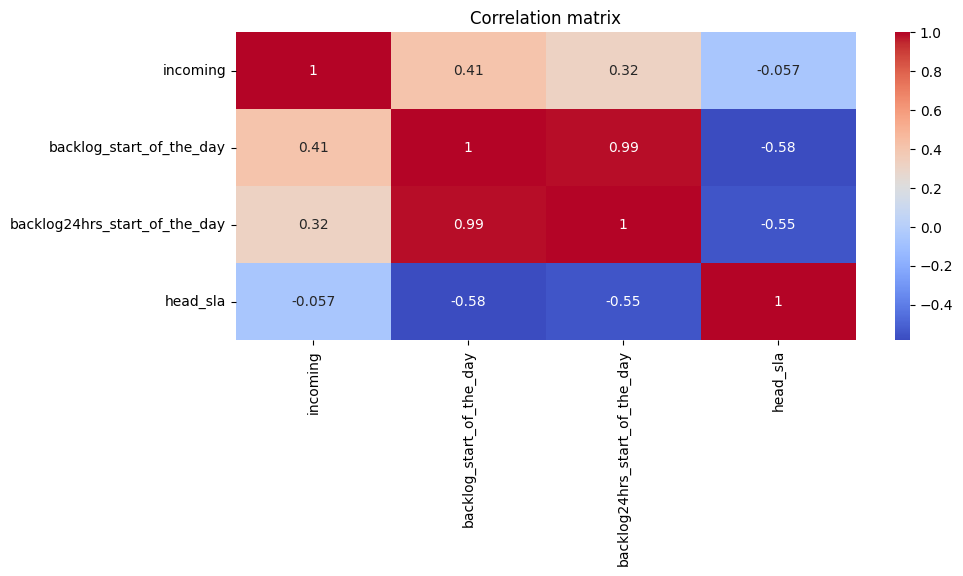

In [362]:
correlation_metrics = ['incoming', 'backlog_start_of_the_day', 'backlog24hrs_start_of_the_day', 'head_sla']
correlation_matrix = df[correlation_metrics].corr()
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

correlated: incoming vs head_sla, incoming vs backlog24hrs_start_of_the_day

In [363]:
# langauge performance
language_performance = df.groupby('contact_language').agg({"head_sla": "mean",
                                                           "backlog_start_of_the_day": "mean",
                                                           "backlog24hrs_start_of_the_day": "mean"}).round(2)

language_performance

,head_sla,backlog_start_of_the_day,backlog24hrs_start_of_the_day
contact_language,,,
de,0.66,2382.57,1640.78
en,0.73,1435.89,1008.65
es,0.68,583.07,384.77
fr,0.64,1049.22,692.91
it,0.84,169.75,79.97


#### Head SLA vs. Backlog

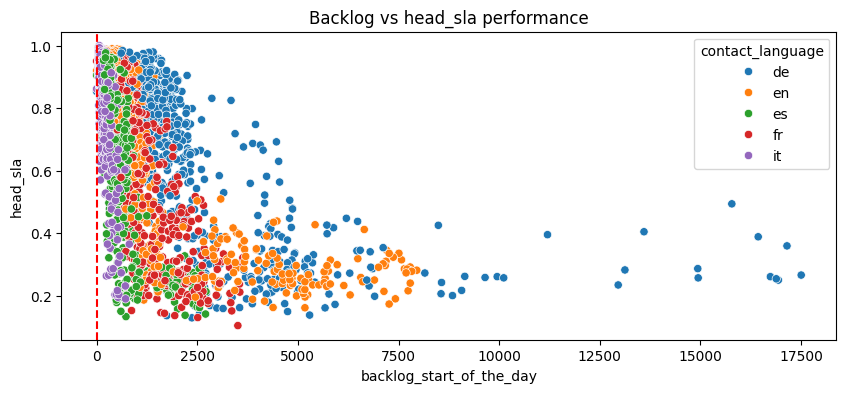

In [364]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='backlog_start_of_the_day', y='head_sla', hue='contact_language')
plt.axvline(x=0.20, color='r', linestyle='--', label='20% threshold')
plt.title('Backlog vs head_sla performance')
plt.show()

We notice xxx

### Daily trends

In [365]:
def analyze_email_flow(df):
    # Emails answered within 24 hours
    df['answered_within_24h'] = df['incoming'] * df['head_sla']
    
    # Emails not answered within 24 hours
    df['not_answered_24h'] = df['incoming'] - df['answered_within_24h']
    
    # Backlogs younger than 24 hours (not resolved)
    df['backlog_younger_24h'] = df['backlog_start_of_the_day'] - df['backlog24hrs_start_of_the_day']
    
    # Emails resolved from the previous day's backlog
    df['resolved_from_previous_day'] = df['backlog_start_of_the_day'] - df['backlog_younger_24h']
    
    # Actual new backlog (new unresolved emails added today)
    df['actual_new_backlog'] = df['backlog_start_of_the_day'] + df['incoming'] - df['answered_within_24h']
    df['actual_new_backlog'] = df['actual_new_backlog'].clip(lower=0)
    
    # Emails that aged into the backlog > 24h category
    df['new_aged_to_24h'] = df['backlog24hrs_start_of_the_day'] - df['resolved_from_previous_day']
    df['new_aged_to_24h'] = df['new_aged_to_24h'].clip(lower=0)

    # Efficiency ratio (higher = better resolution rate)
    df['efficiency_ratio'] = (df['incoming'] + df['backlog_start_of_the_day'] - df['actual_new_backlog']) / (df['incoming'] + df['backlog_start_of_the_day'])
    
    return df

df = analyze_email_flow(df)
df.head()

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow,incoming_zscore,backlog_zscore,outlier_incoming,outlier_backlog,answered_within_24h,not_answered_24h,backlog_younger_24h,resolved_from_previous_day,actual_new_backlog,new_aged_to_24h,efficiency_ratio
0,2023-01-31,de,1716.0,0.0,0.0,0.853147,Tuesday,1.713395,-0.625446,0,0,1464.0,252.0,0.0,0.0,252.0,0.0,0.853147
1,2023-01-31,en,1145.0,0.0,0.0,0.919651,Tuesday,0.722485,-0.625446,0,0,1053.0,92.0,0.0,0.0,92.0,0.0,0.919651
2,2023-01-31,es,390.0,0.0,0.0,0.905128,Tuesday,-0.587738,-0.625446,0,0,353.0,37.0,0.0,0.0,37.0,0.0,0.905128
3,2023-01-31,fr,664.0,0.0,0.0,0.950301,Tuesday,-0.112240,-0.625446,0,0,631.0,33.0,0.0,0.0,33.0,0.0,0.950301
4,2023-01-31,it,354.0,0.0,0.0,0.861582,Tuesday,-0.650212,-0.625446,0,0,305.0,49.0,0.0,0.0,49.0,0.0,0.861582


Example logic flow

Efficiency Ratio is used to track overall backlog health (long-term backlog trends)

In [366]:
print("Email Flow Analysis (1st Row):")
print(f"Incoming emails: {df['incoming'].iloc[0]}")
print(f"Answered within 24h: {df['answered_within_24h'].iloc[0]:.0f}")
print(f"Not answered within 24h: {df['not_answered_24h'].iloc[0]:.0f}")
print(f"Resolved from previous backlog: {df['resolved_from_previous_day'].iloc[0]:.0f}")
print(f"New backlog added today: {df['actual_new_backlog'].iloc[0]:.0f}")
print(f"Emails aged into >24h backlog: {df['new_aged_to_24h'].iloc[0]:.0f}")
print(f"Efficiency ratio: {df['efficiency_ratio'].iloc[0]:.2%}")

Email Flow Analysis (1st Row):
Incoming emails: 1716.0
Answered within 24h: 1464
Not answered within 24h: 252
Resolved from previous backlog: 0
New backlog added today: 252
Emails aged into >24h backlog: 0
Efficiency ratio: 85.31%


### Efficiency by DOW 

In [367]:
dow_summary = df.groupby("dow").agg({"incoming": "mean",
                                    "backlog_start_of_the_day": "mean",
                                    "backlog24hrs_start_of_the_day": "mean",
                                    "head_sla": "mean",
                                    "efficiency_ratio":"mean"}).reset_index()

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_summary['dow'] = pd.Categorical(dow_summary['dow'], categories=dow_order, ordered=True)
dow_summary = dow_summary.sort_values('dow')
dow_summary

,dow,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,efficiency_ratio
1,Monday,889.398438,971.119141,787.117188,0.779180,0.468187
5,Tuesday,906.140927,1037.451737,625.384170,0.766746,0.454000
6,Wednesday,878.420849,1057.664093,637.700772,0.743383,0.425142
4,Thursday,846.639692,1083.539499,659.364162,0.712755,0.397948
0,Friday,756.848249,1116.192607,683.145914,0.627478,0.332393
2,Saturday,363.573077,1277.523077,863.211538,0.586447,0.220539
3,Sunday,326.878846,1239.819231,1014.784615,0.743153,0.260638


📌 Workload is front-loaded (Monday has the most new emails), but backlog isn’t clearing fast enough.

📌 Response efficiency (head_sla) drops throughout the week.

📌 Weekend backlog accumulates, likely due to lower staffing or response rates.

/var/folders/ld/t4l42g9d2kndcwfk5qh21smc0000gp/T/ipykernel_4797/2324819101.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_df = df.groupby(["dow", "backlog_bin"])["efficiency_ratio"].mean().unstack()


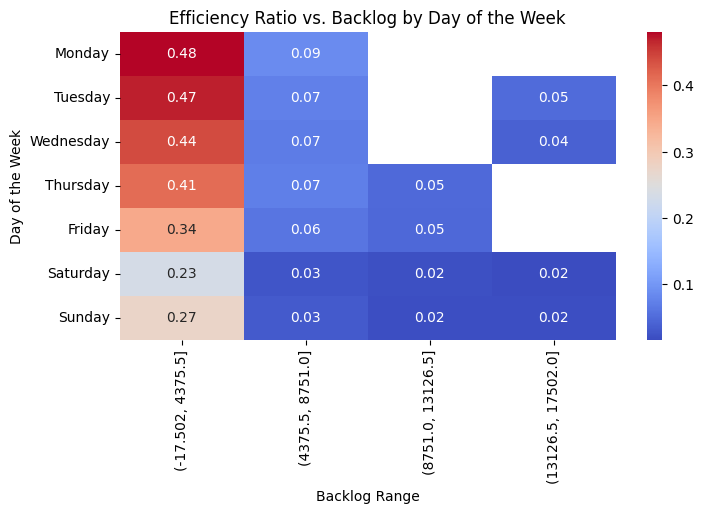

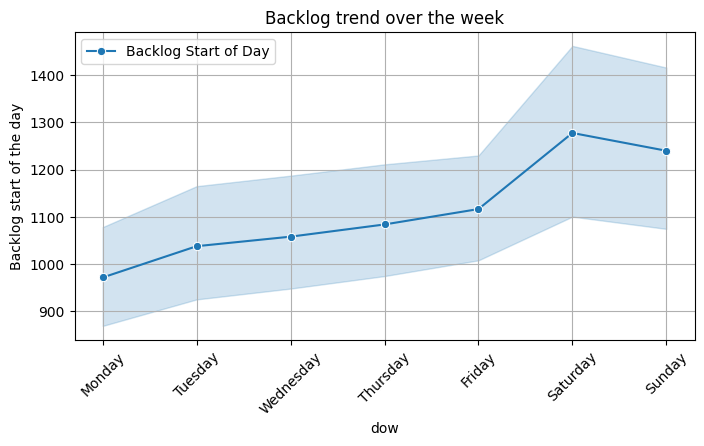

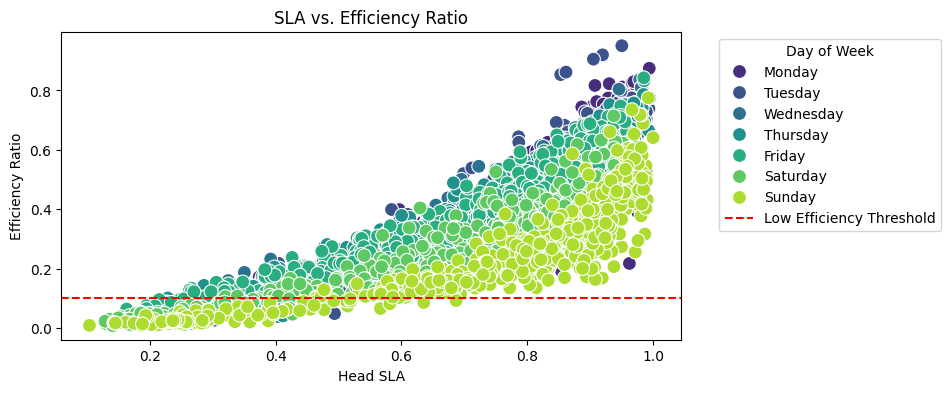

In [368]:
# Convert categorical 'dow' to ordered categorical type for sorting
df["dow"] = pd.Categorical(df["dow"], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
df = df.sort_values("dow")

# --- 1. Heatmap of backlog vs. efficiency ratio ---
df["backlog_bin"] = pd.cut(df["backlog_start_of_the_day"], bins=4)  # Adjust bins as needed
pivot_df = df.groupby(["dow", "backlog_bin"])["efficiency_ratio"].mean().unstack()
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Efficiency Ratio vs. Backlog by Day of the Week")
plt.ylabel("Day of the Week")
plt.xlabel("Backlog Range")
plt.show()

# --- 2. Line chart of backlog trend over the week ---
plt.figure(figsize=(8, 4))
sns.lineplot(x=df["dow"], y=df["backlog_start_of_the_day"], marker="o", label="Backlog Start of Day")
plt.xticks(rotation=45)
plt.title("Backlog trend over the week")
plt.ylabel("Backlog start of the day")
plt.grid(True)
plt.show()

# --- 3. Scatter plot: head_sla vs. efficiency ---
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df["head_sla"], y=df["efficiency_ratio"], hue=df["dow"], palette="viridis", s=100)
plt.title("SLA vs. Efficiency Ratio")
plt.xlabel("Head SLA")
plt.ylabel("Efficiency Ratio")
plt.axhline(0.1, linestyle="--", color="red", label="Low Efficiency Threshold")
plt.legend(title="Day of Week", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [369]:
# filter those rows which effiency is lower than 50%
df_low_eff = df[df['efficiency_ratio'] < 0.5]
df_low_eff

,day,contact_language,incoming,backlog_start_of_the_day,backlog24hrs_start_of_the_day,head_sla,dow,incoming_zscore,backlog_zscore,outlier_incoming,outlier_backlog,answered_within_24h,not_answered_24h,backlog_younger_24h,resolved_from_previous_day,actual_new_backlog,new_aged_to_24h,efficiency_ratio,backlog_bin
2831,2024-08-19,en,773.0,940.0,673.0,0.677878,Monday,0.076918,-0.145796,0,0,524.0,249.0,267.0,673.0,1189.0,0.0,0.305896,"(-17.502, 4375.5]"
2832,2024-08-19,es,347.0,1620.0,1476.0,0.291066,Monday,-0.662360,0.201185,0,0,101.0,246.0,144.0,1476.0,1866.0,0.0,0.051347,"(-17.502, 4375.5]"
2833,2024-08-19,fr,621.0,2139.0,1948.0,0.273752,Monday,-0.186862,0.466012,0,0,170.0,451.0,191.0,1948.0,2590.0,0.0,0.061594,"(-17.502, 4375.5]"
3251,2024-11-11,en,1244.0,5074.0,4619.0,0.255627,Monday,0.894289,1.963642,0,0,318.0,926.0,455.0,4619.0,6000.0,0.0,0.050332,"(4375.5, 8751.0]"
3252,2024-11-11,es,569.0,723.0,542.0,0.722320,Monday,-0.277102,-0.256524,0,0,411.0,158.0,181.0,542.0,881.0,0.0,0.318111,"(-17.502, 4375.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,2024-10-20,en,313.0,3874.0,3469.0,0.188498,Sunday,-0.721363,1.351323,0,0,59.0,254.0,405.0,3469.0,4128.0,0.0,0.014091,"(-17.502, 4375.5]"
3142,2024-10-20,es,114.0,475.0,309.0,0.833333,Sunday,-1.066707,-0.383070,0,0,95.0,19.0,166.0,309.0,494.0,0.0,0.161290,"(-17.502, 4375.5]"
3143,2024-10-20,fr,323.0,1411.0,973.0,0.492260,Sunday,-0.704010,0.094539,0,0,159.0,164.0,438.0,973.0,1575.0,0.0,0.091696,"(-17.502, 4375.5]"
2408,2024-05-26,fr,225.0,750.0,532.0,0.768889,Sunday,-0.874078,-0.242747,0,0,173.0,52.0,218.0,532.0,802.0,0.0,0.177436,"(-17.502, 4375.5]"


### Scenario modeling

In [370]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['incoming', 'backlog24hrs_start_of_the_day']]  # independent variables
y = df['head_sla']  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)  

y_pred = model.predict(X_test_scaled)


In [371]:
# evaluate lr mdoel
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

new_df = pd.DataFrame({
    'incoming': [2560], 
    'backlog24hrs_start_of_the_day': [356]})

new_df_scaled = scaler.transform(new_df)

# Make the prediction for the new data
predicted_sla = model.predict(new_df_scaled)
print(f"Predicted SLA: {predicted_sla[0]}")

Mean Squared Error: 0.03701889651946841
Predicted SLA: 0.8487330633990685


In [372]:
coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_})

coefficients

,feature,coefficient
0,incoming,0.029193
1,backlog24hrs_start_of_the_day,-0.134971


- This indicates a negative relationship between backlog24hrs_start_of_the_day and head_sla. 
- If backlog24hrs_start_of_the_day increases, head_sla will decrease, and the effect is more pronounced than the one for incoming

In [373]:
threshold = 80   #sla target
critical_backlog = df[df['head_sla'] < threshold]['backlog24hrs_start_of_the_day'].median()
print(f"Backlog exceeding {critical_backlog} correlates with SLA < {threshold}%")

Backlog exceeding 353.0 correlates with SLA < 80%


**Threshold: Wr set a target SLA value of 80%. This means looking for data points where head_sla is below 80%.**

**Critical Backlog**: The critical_backlog is calculated as the median of the backlog24hrs_start_of_the_day values for rows where the SLA is below 80%.

353 value indicates that for backlogs exceeding 353, the `head_sla` tends to be below 80%. When the backlog is greater than 353, it's more likely that the SLA will be under 80%.

**Insight**: The output suggests that if the backlog at the start of the day (i.e., backlog24hrs_start_of_the_day) is greater than 353, there's a higher probability that the head SLA will be below 80%. 

Using regression to answer "what-if" questions:

- If we reduce incoming emails by 20%, how much would SLA improve?

In [376]:
new_df = pd.DataFrame({'incoming': [500], 
                       'backlog24hrs_start_of_the_day': [65]})

predicted_sla = model.predict(new_df)
print(f"Predicted SLA: {predicted_sla[0]:.2f}%")

Predicted SLA: 6.53%


/Users/krisi.afezolli/Desktop/Folder/granger_statistics/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [380]:
threshold = 80  #sla target
critical_backlog = df[df['head_sla'] < threshold]['backlog24hrs_start_of_the_day'].median()
print(f"Backlog exceeding {critical_backlog} correlates with SLA < {threshold}%")   

Backlog exceeding 353.0 correlates with SLA < 80%
